In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

sns.set_style('whitegrid')

In [13]:
df = pd.read_csv('../data/processed/part-00000-cd530e15-795d-43aa-9731-3388b87f5dc7-c000.csv')
df['date'] = pd.to_datetime(df['date'])

# Sort by ticker and date
df = df.sort_values(['ticker', 'date']).reset_index(drop=True)

# Check structure
print(df.head())
print(df.info())

# ✅ Fill missing values if any
df.fillna(0, inplace=True)

  ticker       date     open     high      low    close     volume  \
0   AAPL 2020-09-29  111.697  112.436  110.739  111.243  102615780   
1   AAPL 2020-09-30  110.958  114.345  110.788  112.918  146318692   
2   AAPL 2020-10-01  114.704  114.782  112.937  113.885  119085817   
3   AAPL 2020-10-02  110.089  112.486  109.429  110.219  148407508   
4   AAPL 2020-10-05  111.078  113.746  110.720  113.597  108956998   

   post_count  avg_score  total_score  avg_comments  max_score  
0           0        0.0            0           0.0          0  
1           0        0.0            0           0.0          0  
2           0        0.0            0           0.0          0  
3           0        0.0            0           0.0          0  
4           0        0.0            0           0.0          0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831 entries, 0 to 830
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        -------------- 

In [14]:
df['close_next'] = df.groupby('ticker')['close'].shift(-1)
df['direction'] = (df['close_next'] > df['close']).astype(int)
df.dropna(inplace=True)

feature_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'post_count', 'avg_score', 'total_score',
    'avg_comments', 'max_score'
]
target_col = 'direction'

In [15]:
SEQ_LEN = 5  # past 5 days
X, y = [], []

tickers = df['ticker'].unique()
for t in tickers:
    df_t = df[df['ticker'] == t].sort_values('date')
    features = df_t[feature_cols].values
    targets = df_t[target_col].values
    for i in range(SEQ_LEN, len(df_t)):
        X.append(features[i-SEQ_LEN:i])
        y.append(targets[i])

X = np.array(X)
y = np.array(y)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (783, 5, 10)
Shape of y: (783,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [17]:
scaler = StandardScaler()
# Flatten for scaling
nsamples, nseq, nfeat = X_train.shape
X_train_flat = X_train.reshape((nsamples, nseq*nfeat))
X_test_flat = X_test.reshape((X_test.shape[0], nseq*nfeat))

X_train_scaled = scaler.fit_transform(X_train_flat).reshape((nsamples, nseq, nfeat))
X_test_scaled = scaler.transform(X_test_flat).reshape((X_test.shape[0], nseq, nfeat))

In [18]:
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, len(feature_cols)), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/home/akstrov/miniforge3/envs/py311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,313 (83.25 KB)

 Trainable params: 21,313 (83.25 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4956 - loss: 0.6998 - val_accuracy: 0.4603 - val_loss: 0.6885
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5258 - loss: 0.6900 - val_accuracy: 0.4762 - val_loss: 0.6927
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5240 - loss: 0.6919 - val_accuracy: 0.3810 - val_loss: 0.7187
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5400 - loss: 0.6900 - val_accuracy: 0.3810 - val_loss: 0.7166
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5382 - loss: 0.6862 - val_accuracy: 0.4127 - val_loss: 0.7186
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5560 - loss: 0.6846 - val_accuracy: 0.4127 - val_loss: 0.7193
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5613 - loss: 0.6859 - val_accuracy: 0.4603 - val_loss: 0.7236
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5595 - loss: 0.6832 - val_accuracy: 0.4286 - val_loss

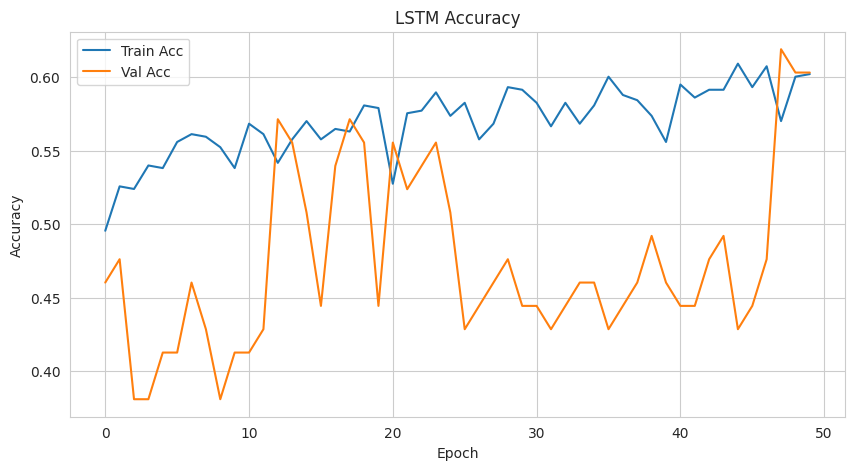

In [20]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Test Accuracy: 0.554140127388535
Confusion Matrix:
 [[29 41]
 [29 58]]


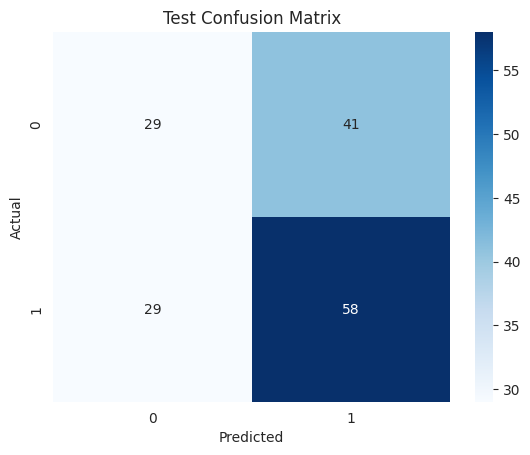

In [21]:
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Test Accuracy:", acc)
print("Confusion Matrix:\n", cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()

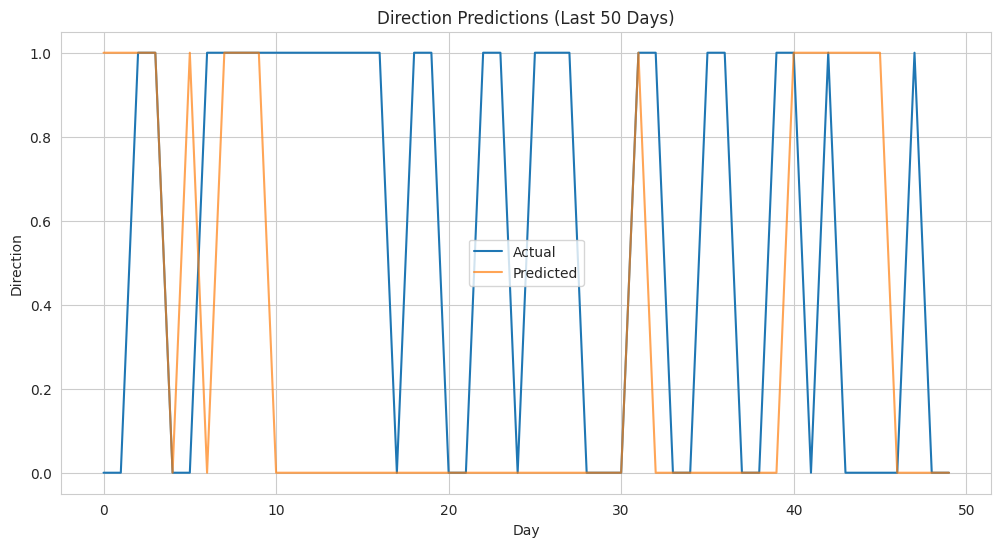

In [22]:
plt.figure(figsize=(12,6))
plt.plot(y_test[-50:], label='Actual')
plt.plot(y_pred[-50:], label='Predicted', alpha=0.7)
plt.title('Direction Predictions (Last 50 Days)')
plt.xlabel('Day')
plt.ylabel('Direction')
plt.legend()
plt.show()

In [23]:
import joblib

joblib.dump(model, "../ml_models/baseline_model.joblib")


['../ml_models/baseline_model.joblib']